# **SARIMA Model**



In [0]:
import statsmodels.api as sm
import warnings
import pandas as pd
from random import randrange
from pandas import Series
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [0]:
march = pd.read_csv("march_new.csv",skiprows = 3)
may = pd.read_csv("may_new.csv",skiprows =3)
july = pd.read_csv("july_new.csv",skiprows =3)
july = july[252:] 

In [0]:
july = july.reset_index(drop=True)
print(july.head())

         Date     Open     High      Low    Close
0  11/14/2017   994.00   994.00   994.00   994.00
1  11/15/2017  1000.25  1000.25  1000.25  1000.25
2  11/16/2017   998.50   998.50   998.50   998.50
3  11/17/2017  1011.75  1011.75  1011.75  1011.75
4  11/20/2017  1013.75  1013.75  1013.75  1013.75


In [0]:
#defining the Sarima model
def SARIMAmodel(data, data_diff, div, ordr, s_ordr, weekday, last):
  train_ar, test_ar= data_diff[0:div], data_diff[div:]
  last_friday = data[0:div][div-1]
  history = [x for x in train_ar]
  predictions = list()

  # predicting for next N days
  week_abs = 0
  N = 5 #min(5, len(test_ar))
  warnings.filterwarnings("ignore")
  model = sm.tsa.statespace.SARIMAX(endog=history, order=ordr, seasonal_order=s_ordr,
                             enforce_invertibility=False)
  model_fit = model.fit()
  output = model_fit.forecast(N)

  naive = [last_friday]*N
  actual_test_price = list(data[div:][0:N])
  avg=0
  for x in data[0:div][div-5:div]:
    avg += x
  avg = avg/5
  for x in range(N):
    val = (avg + output[x])
    predictions.append((val+last_friday)/2)
  
  if last == True:
    print("Predicted: ", predictions)
    print()
    return 0, 0, predictions, [], 0, weekday

  print("Actual: ", actual_test_price)
  print("Predicted: ", predictions)

  error = []
  for x in range(N):
    week_abs = week_abs + abs(predictions[x]-actual_test_price[x])
    error.append(predictions[x]-actual_test_price[x])
    weekday[x] = weekday[x] + predictions[x]-actual_test_price[x]

  print("Error: ", error)
  #print(predictions)
  mae = mean_absolute_error(actual_test_price, predictions)
  mae_same = mean_absolute_error(actual_test_price, naive)
  return mae, mae_same, predictions, naive, week_abs, weekday

In [0]:
#predicting using SARIMA model and plotting the results
def predict(month, data, data_diff, div, ordr, s_ordr, filename):
  test_data = list(data[div:])
  predictions = list()
  naive = list()
  weekday = [0, 0, 0, 0, 0]
  total = 0
  cnt = 0
  last = False
  print("Sarima Model for {} contracts\n".format(month))
  while div <= len(data):
    if div == len(data):
      last = True
    mae, mae_naive, pre, nve, abs_week, weekday = SARIMAmodel(data, data_diff, div, ordr, s_ordr, weekday, last)
    naive.extend(nve)
    predictions.extend(pre)
    total = total + abs_week
    div += min(5, len(data)-div+1)
    cnt = cnt + 1
    print("Week " , cnt, "sarima " , mae, "naive ", mae_naive)
    print()
  
  print("Weekday error")
  for x in range(5):
    print(x, weekday[x]/cnt)
  print()

  sarima_mae = mean_absolute_error(predictions[0:-5], test_data)
  naive_mae = mean_absolute_error(naive, test_data)
  print("Average MAE for {} using each step: ".format(month), "[SARIMA] ", sarima_mae, "[Naive] ",naive_mae)
  moveToCSV(predictions, test_data, filename)
  plotGraph(month, test_data, predictions, naive)
  return total

In [0]:
#plotting the actual and predicted data
def plotGraph(month, test_data, predictions, naive):
  plt.figure(figsize=(12,7))
  plt.plot(test_data, color='blue', label='{}: Actual Test Prices'.format(month))
  plt.plot(predictions, color='green', linestyle='dashed', 
           label='Predicted Prices')
  plt.plot(naive, color='red', linestyle='dashed', 
          label='Naive Prices')
  plt.title('SARIMA model for {} Contracts'.format(month))
  plt.xlabel('Dates')
  plt.ylabel('Prices')
  plt.legend(loc='best')

In [0]:
#expoting data to csv
def moveToCSV(pre, testval, filename):
  predictions = list(pre)
  test = list(testval)
  error = [0] * len(predictions)
  for x in range(len(test)):
    error[x] = (predictions[x]-test[x])
  for x in range(5):
    test.append(0)
  df = pd.DataFrame({'Test':test, 'Predictions':predictions, 'Error': error})
  df.to_csv(filename, sep=',', encoding='utf-8')

In [0]:
def getConsecutiveDifference(data, div):
  diff=[]
  for i in range(5, len(data)):
    diff.append(data[i]-data[i-5]);
  return diff

In [1]:
#differences
div = 422
march_diff = getConsecutiveDifference(march['Close'], div)
may_diff = getConsecutiveDifference(may['Close'], div)
july_diff = getConsecutiveDifference(july['Close'], div)

NameError: ignored

Sarima Model for March Difference contracts

Actual:  [928.25, 926.25, 931.0, 924.5, 925.75]
Predicted:  [928.8980966859637, 928.2568317404075, 928.0423435811649, 928.3818383916184, 929.1552725261694]
Error:  [0.648096685963651, 2.006831740407506, -2.957656418835086, 3.8818383916184303, 3.4052725261693695]
Week  1 sarima  2.5799391525988087 naive  13.35

Actual:  [929.25, 922.25, 908.5, 891.75, 894.25]
Predicted:  [911.0009460466476, 911.1772658511057, 911.1087330402559, 911.8612156094002, 912.2306467804116]
Error:  [-18.24905395335236, -11.072734148894256, 2.6087330402558564, 20.111215609400233, 17.980646780411575]
Week  2 sarima  14.004476706462857 naive  17.95

Actual:  [893.75, 890.75, 891.75, 907.5, 916.0]
Predicted:  [912.0991971463877, 910.4920607680633, 910.1039276398772, 909.9472680109694, 909.2141139736843]
Error:  [18.349197146387723, 19.74206076806331, 18.353927639877156, 2.447268010969424, -6.785886026315666]
Week  3 sarima  13.135667918322657 naive  8.3

Actual:  [905.25,

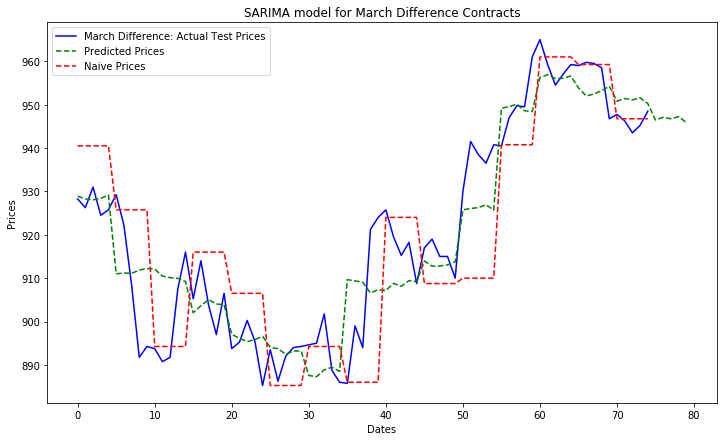

In [0]:
march_diff_total = predict("March Difference", march['Close'], march_diff, div, (1, 1, 1), (1, 1, 1, 4), "march_SARIMA_diff.csv")

Sarima Model for May Difference contracts

Actual:  [937.0, 935.25, 940.5, 934.5, 935.75]
Predicted:  [938.0525758375605, 937.4346318056403, 937.1587835028736, 937.4669575897476, 938.1836441591986]
Error:  [1.0525758375605392, 2.184631805640265, -3.3412164971264247, 2.966957589747608, 2.433644159198593]
Week  1 sarima  2.395805177854686 naive  12.15

Actual:  [939.0, 933.25, 920.5, 903.5, 905.75]
Predicted:  [921.4426794438322, 921.5120492488768, 921.4873177892276, 922.1914831423824, 922.5834512808624]
Error:  [-17.557320556167838, -11.737950751123208, 0.9873177892276317, 18.691483142382367, 16.83345128086239]
Week  2 sarima  13.161504703952687 naive  16.65

Actual:  [905.25, 902.0, 903.0, 918.5, 927.0]
Predicted:  [923.2272486188144, 921.7639166968416, 921.3922263133409, 921.2768173826199, 920.4981792962976]
Error:  [17.97724861881443, 19.763916696841648, 18.39222631334087, 2.7768173826199245, -6.5018207037023785]
Week  3 sarima  13.08240594306385 naive  8.2

Actual:  [917.0, 925.25, 

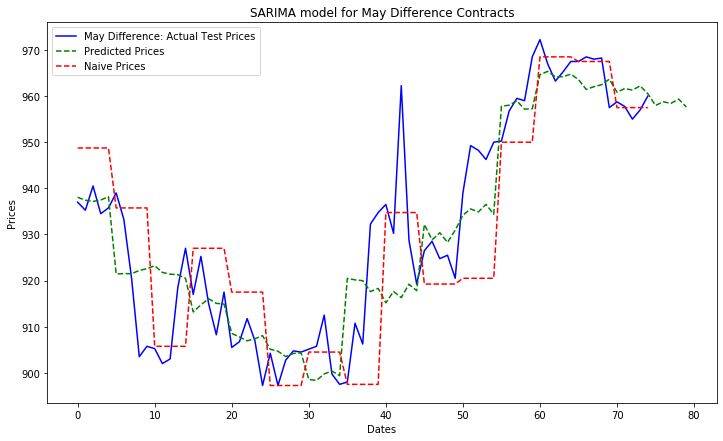

In [0]:
may_diff_total = predict("May Difference", may['Close'], may_diff, div, (1, 1, 1), (1, 1, 1, 4), 'may_SARIMA_diff.csv')

Sarima Model for July Difference contracts

Actual:  [945.5, 944.25, 949.25, 943.75, 945.25]
Predicted:  [946.9086378701015, 946.238889882703, 945.9706012552035, 946.3346671783115, 947.0277936825507]
Error:  [1.4086378701015292, 1.9888898827030062, -3.279398744796481, 2.58466717831152, 1.7777936825507368]
Week  1 sarima  2.2078774716926546 naive  10.9

Actual:  [948.75, 944.0, 931.75, 915.25, 917.25]
Predicted:  [931.6413597274916, 931.7082019868074, 931.8073423090968, 932.500969752704, 932.8695752977644]
Error:  [-17.10864027250841, -12.291798013192647, 0.05734230909683902, 17.25096975270401, 15.619575297764413]
Week  2 sarima  12.465665129053264 naive  15.25

Actual:  [916.75, 913.5, 913.75, 929.0, 937.25]
Predicted:  [933.9451413031203, 932.5838200197051, 932.196899777924, 932.0162776581901, 931.2489259070713]
Error:  [17.195141303120295, 19.08382001970506, 18.446899777924045, 3.01627765819012, -6.001074092928661]
Week  3 sarima  12.748642570373637 naive  7.9

Actual:  [927.75, 935.

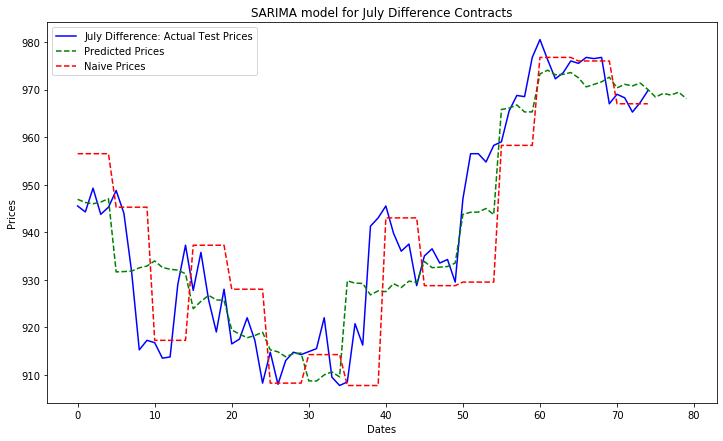

In [0]:
july_diff_total = predict("July Difference", july['Close'], july_diff, div, (1, 1, 1), (1, 1, 1, 4), 'july_SARIMA_diff.csv')

In [0]:
#Optimize
(march_diff_total + may_diff_total + july_diff_total)/15

104.5622326501455